## Machine Learning Algorithms

In this notebook I will develop and deploy some classification algorithms, and find the best one for this specific dataset by accuracy evaluation methods.


Lets first load required libraries:

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import scipy.optimize as opt
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [5]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-29 22:28:37--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-03-29 22:28:37 (13.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [6]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [7]:
df.shape

(346, 10)

### Convert to date time object 

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.10.0             |             py_0         161 KB  anaconda
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2019.11.28         |           py36_1         157 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    ------------------------------------------------------------
                                           Total:         5.5 MB

The following packages will be UPDATED:

    ca-certificates: 2020.1.1-0         --> 2020.1.1-0        anaconda
    certifi:         2019.11.28-py36_0  --> 2019.11.28-py36_1 anaconda
    openssl:         1.1.1e-h7b6447c_0  --> 1.1.1-h7b6447c_0  anaconda
    seaborn:         0.9.0-pyh91

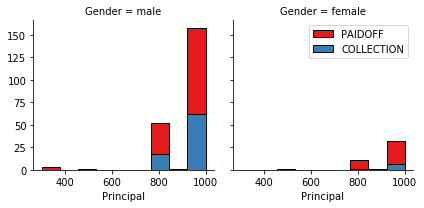

In [10]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

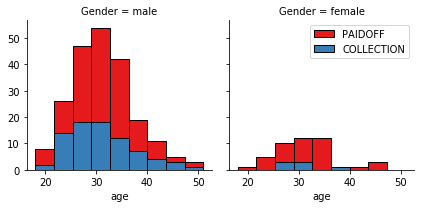

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people tend to apply for a loan 

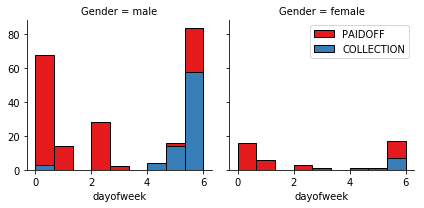

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [19]:
X = Feature
X[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

#### The pink square above is not an error. It is just a warning and it does not impact on the results !!!!

# Classification 

Now, let's go through some ML models and then use the test set to report the accuracy of each model.
You will deploy the following algorithms:

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



# K Nearest Neighbor(KNN)


### Ok! First we split data into train and test. This step will generate the test and train sets to work on our KNN, Decision Tree, SMV and Logistic Regression Models

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### Now we are going to train the KNN model for a series of Ks in order to figure which k leads to the the model with the best accuracy!!!

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 25
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857,
       0.7       , 0.72857143, 0.7       , 0.7       , 0.68571429,
       0.72857143, 0.72857143, 0.72857143, 0.7       , 0.68571429,
       0.71428571, 0.68571429, 0.7       , 0.7       ])

### Now we plot the Metrics for each considered k in our loop.

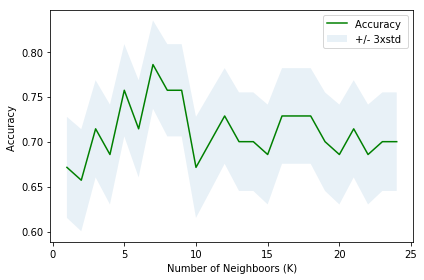

In [24]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighboors (K)')
plt.tight_layout()
plt.show()

### Let's capture the best accurary:

In [25]:
print( "The best accuracy is with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy is with 0.7857142857142857 with k= 7


### Let's fit the model again using k =7

In [168]:
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
yhat=neigh.predict(X_test)
print('Accuracy for KNN with k =7 is', metrics.accuracy_score(y_test, yhat))

Accuracy for KNN with k =7 is 0.7857142857142857


### the best accurary comes from a model with a K equal to 7 !

In [32]:
print( 'F1 is: ', f1_score(y_test, yhat, average='weighted'))

F1 is:  0.7034625628884287


In [33]:
print( 'Jacard is: ', jaccard_similarity_score(y_test, yhat))

Jacard is:  0.7


# Decision Tree

### Modeling a Tree using entrophy as criteria and stablishing a max depth. 
###   First, let's see how Accuracy behaves when we change the max depth paramether 

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [98]:
Dps = 25
mean_acc = np.zeros((Dps-1))
std_acc = np.zeros((Dps-1))

for n in range(1,Dps):
    
    #Train Model and Predict  
    ModelTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    ModelTree.fit(X_train,y_train)
    ForeTree = ModelTree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, ForeTree)
    std_acc[n-1]=np.std(ForeTree==y_test)/np.sqrt(ForeTree.shape[0])

mean_acc
  
    


array([0.78571429, 0.78571429, 0.61428571, 0.61428571, 0.64285714,
       0.77142857, 0.75714286, 0.75714286, 0.65714286, 0.7       ,
       0.7       , 0.7       , 0.7       , 0.71428571, 0.74285714,
       0.68571429, 0.7       , 0.7       , 0.7       , 0.68571429,
       0.68571429, 0.7       , 0.7       , 0.68571429])

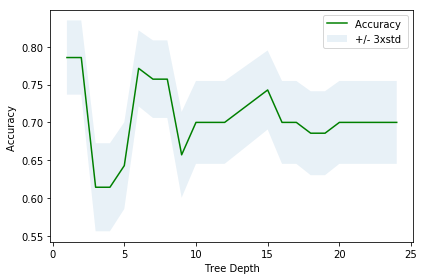

In [91]:
plt.plot(range(1,Dps),mean_acc,'g')
plt.fill_between(range(1,Dps),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Tree Depth')
plt.tight_layout()
plt.show()

### Accuracy is higher when max depth are too low (1 or 2). That wouldn't be reasonable. The second better accuracy for the model, which is depth = 6 seems good enough.

In [100]:
# Modeling the tree
ModelTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)


In [101]:
# training the model
ModelTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [102]:
# Accuracy
ForeTree = ModelTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, ForeTree))

DecisionTrees's Accuracy:  0.7714285714285715


### Let's Visualize the tree:

In [32]:
# Instaling pydotplus
!conda install -c conda-forge pydotplus -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

In [33]:
# installing graphviz
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-graphviz-0.13.2     |             py_0          18 KB  conda-forge

The following NEW packages will be INSTALLED:

    python-graphviz: 0.13.2-py_0 conda-forge


python-graphviz-0.13 | 18 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [59]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

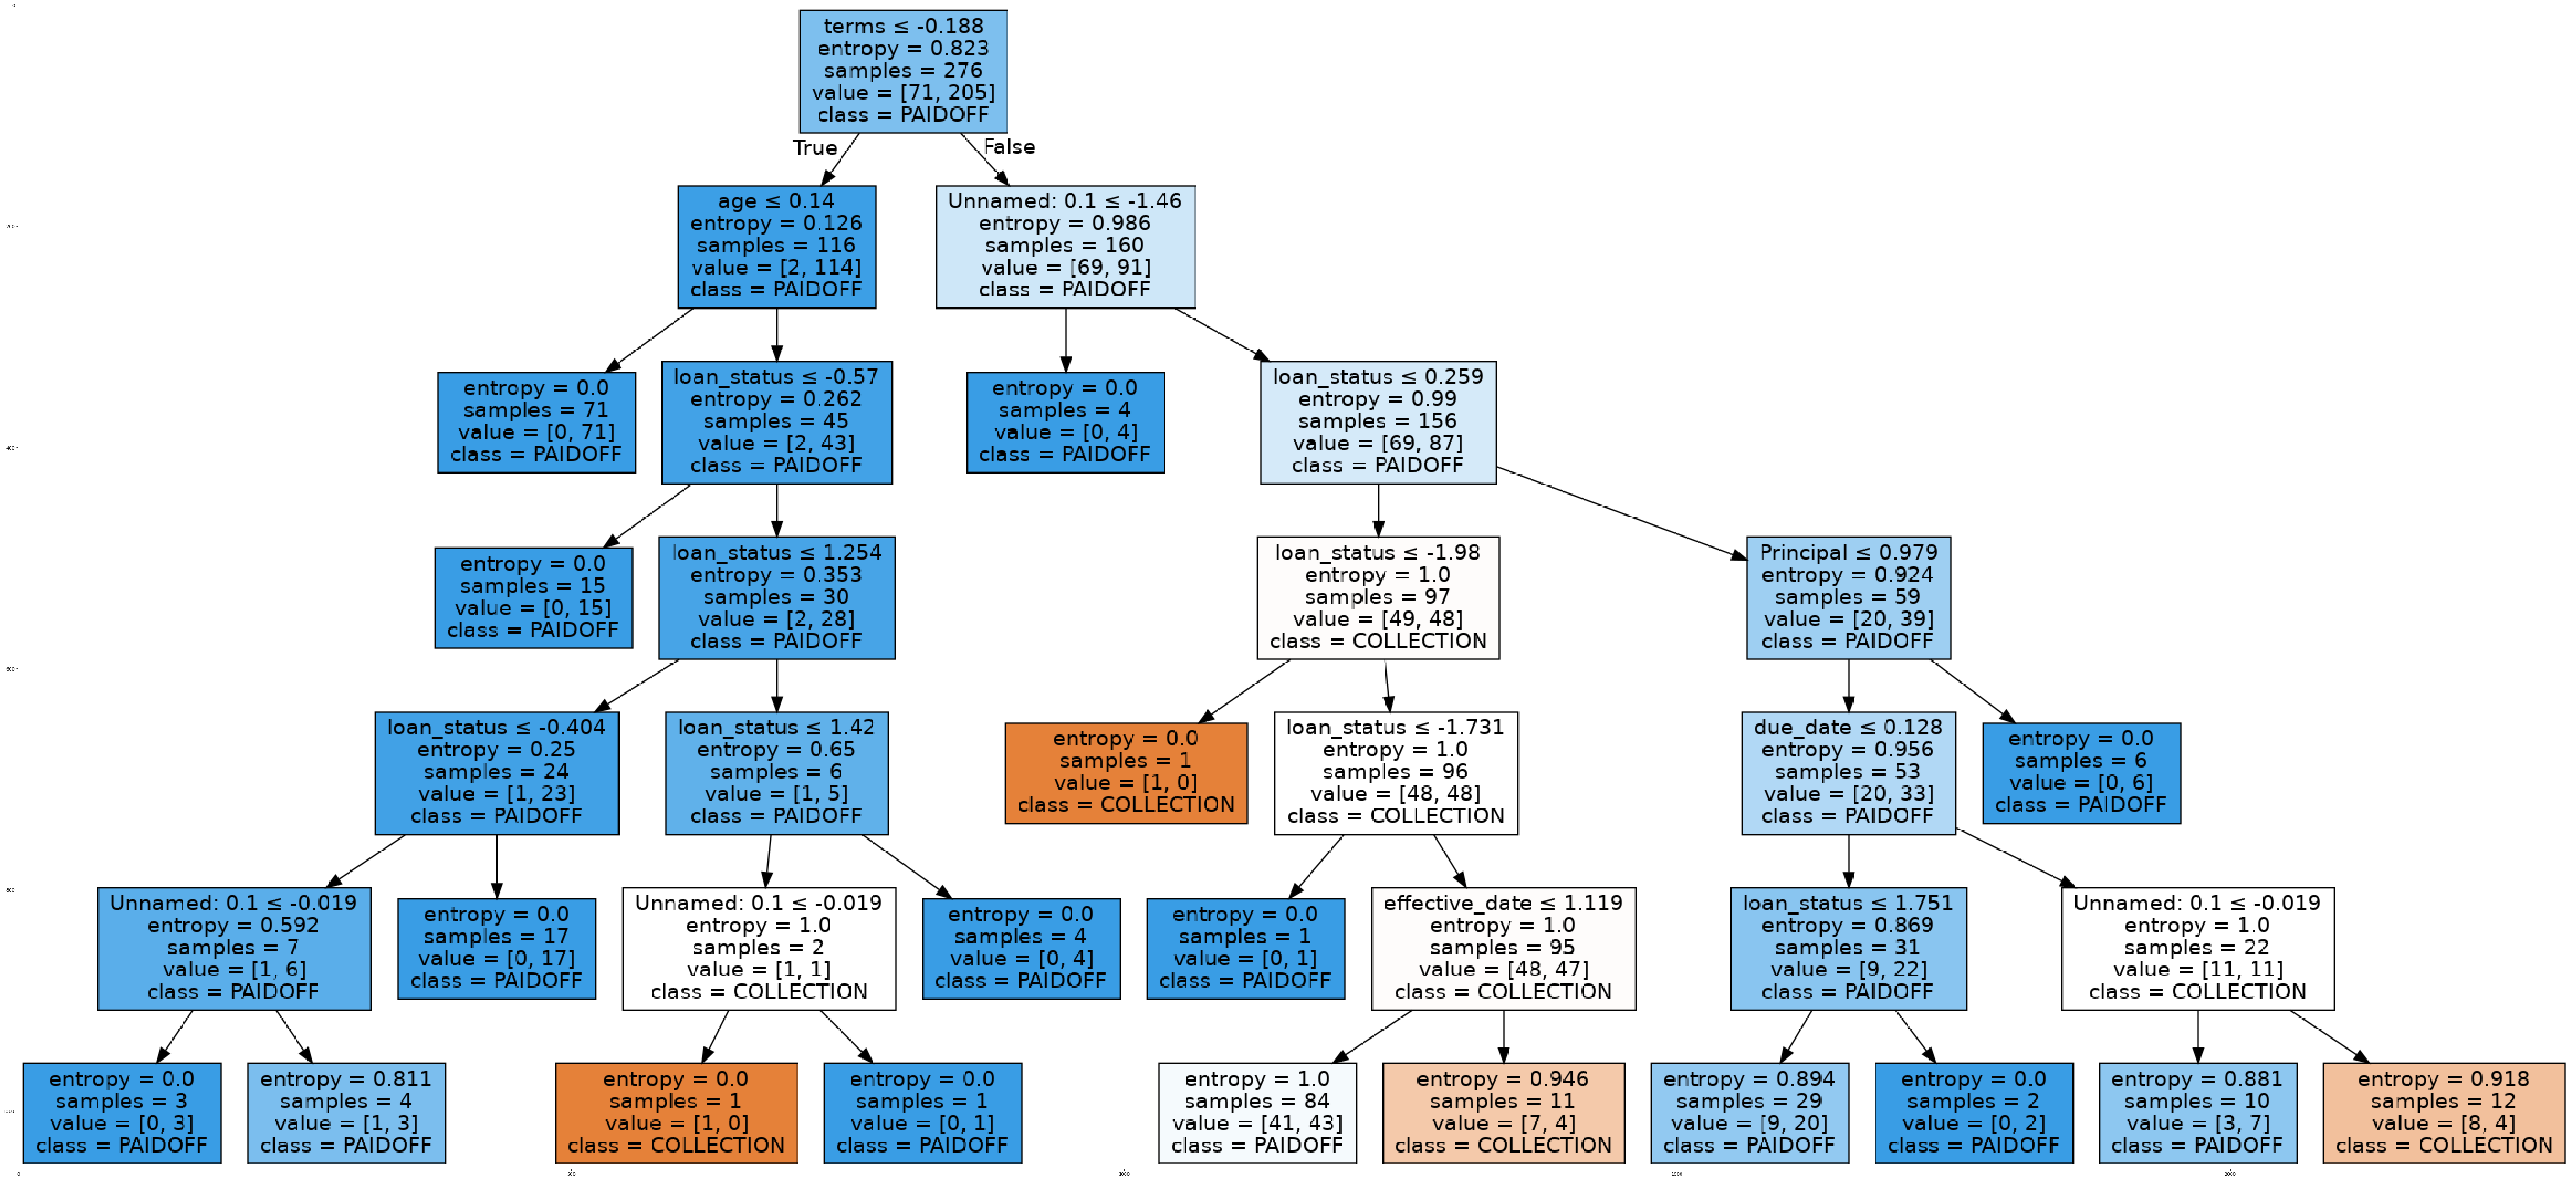

In [103]:
dot_data = StringIO()
filename = "Modeltree.png"
featureNames = df.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(ModelTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### In fact the tree above is the one that has the best accuracy. Nevertheless, it seems instructures are ignoring this fact. So, in order to come up with the expected values lets re train the model with a max depth equal to 4

In [35]:
# Modeling the tree
ModelTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

# training the model
ModelTree.fit(X_train,y_train)

# Accuracy
ForeTree = ModelTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, ForeTree))


DecisionTrees's Accuracy:  0.6142857142857143


In [36]:
print( 'F1 is: ', f1_score(y_test, ForeTree, average='weighted'))

F1 is:  0.6445993031358885


In [37]:
print( 'Jacard is: ', jaccard_similarity_score(y_test, ForeTree))

Jacard is:  0.6142857142857143


### Yeap, accuracy here is lower. Let's Visualize this new tree:

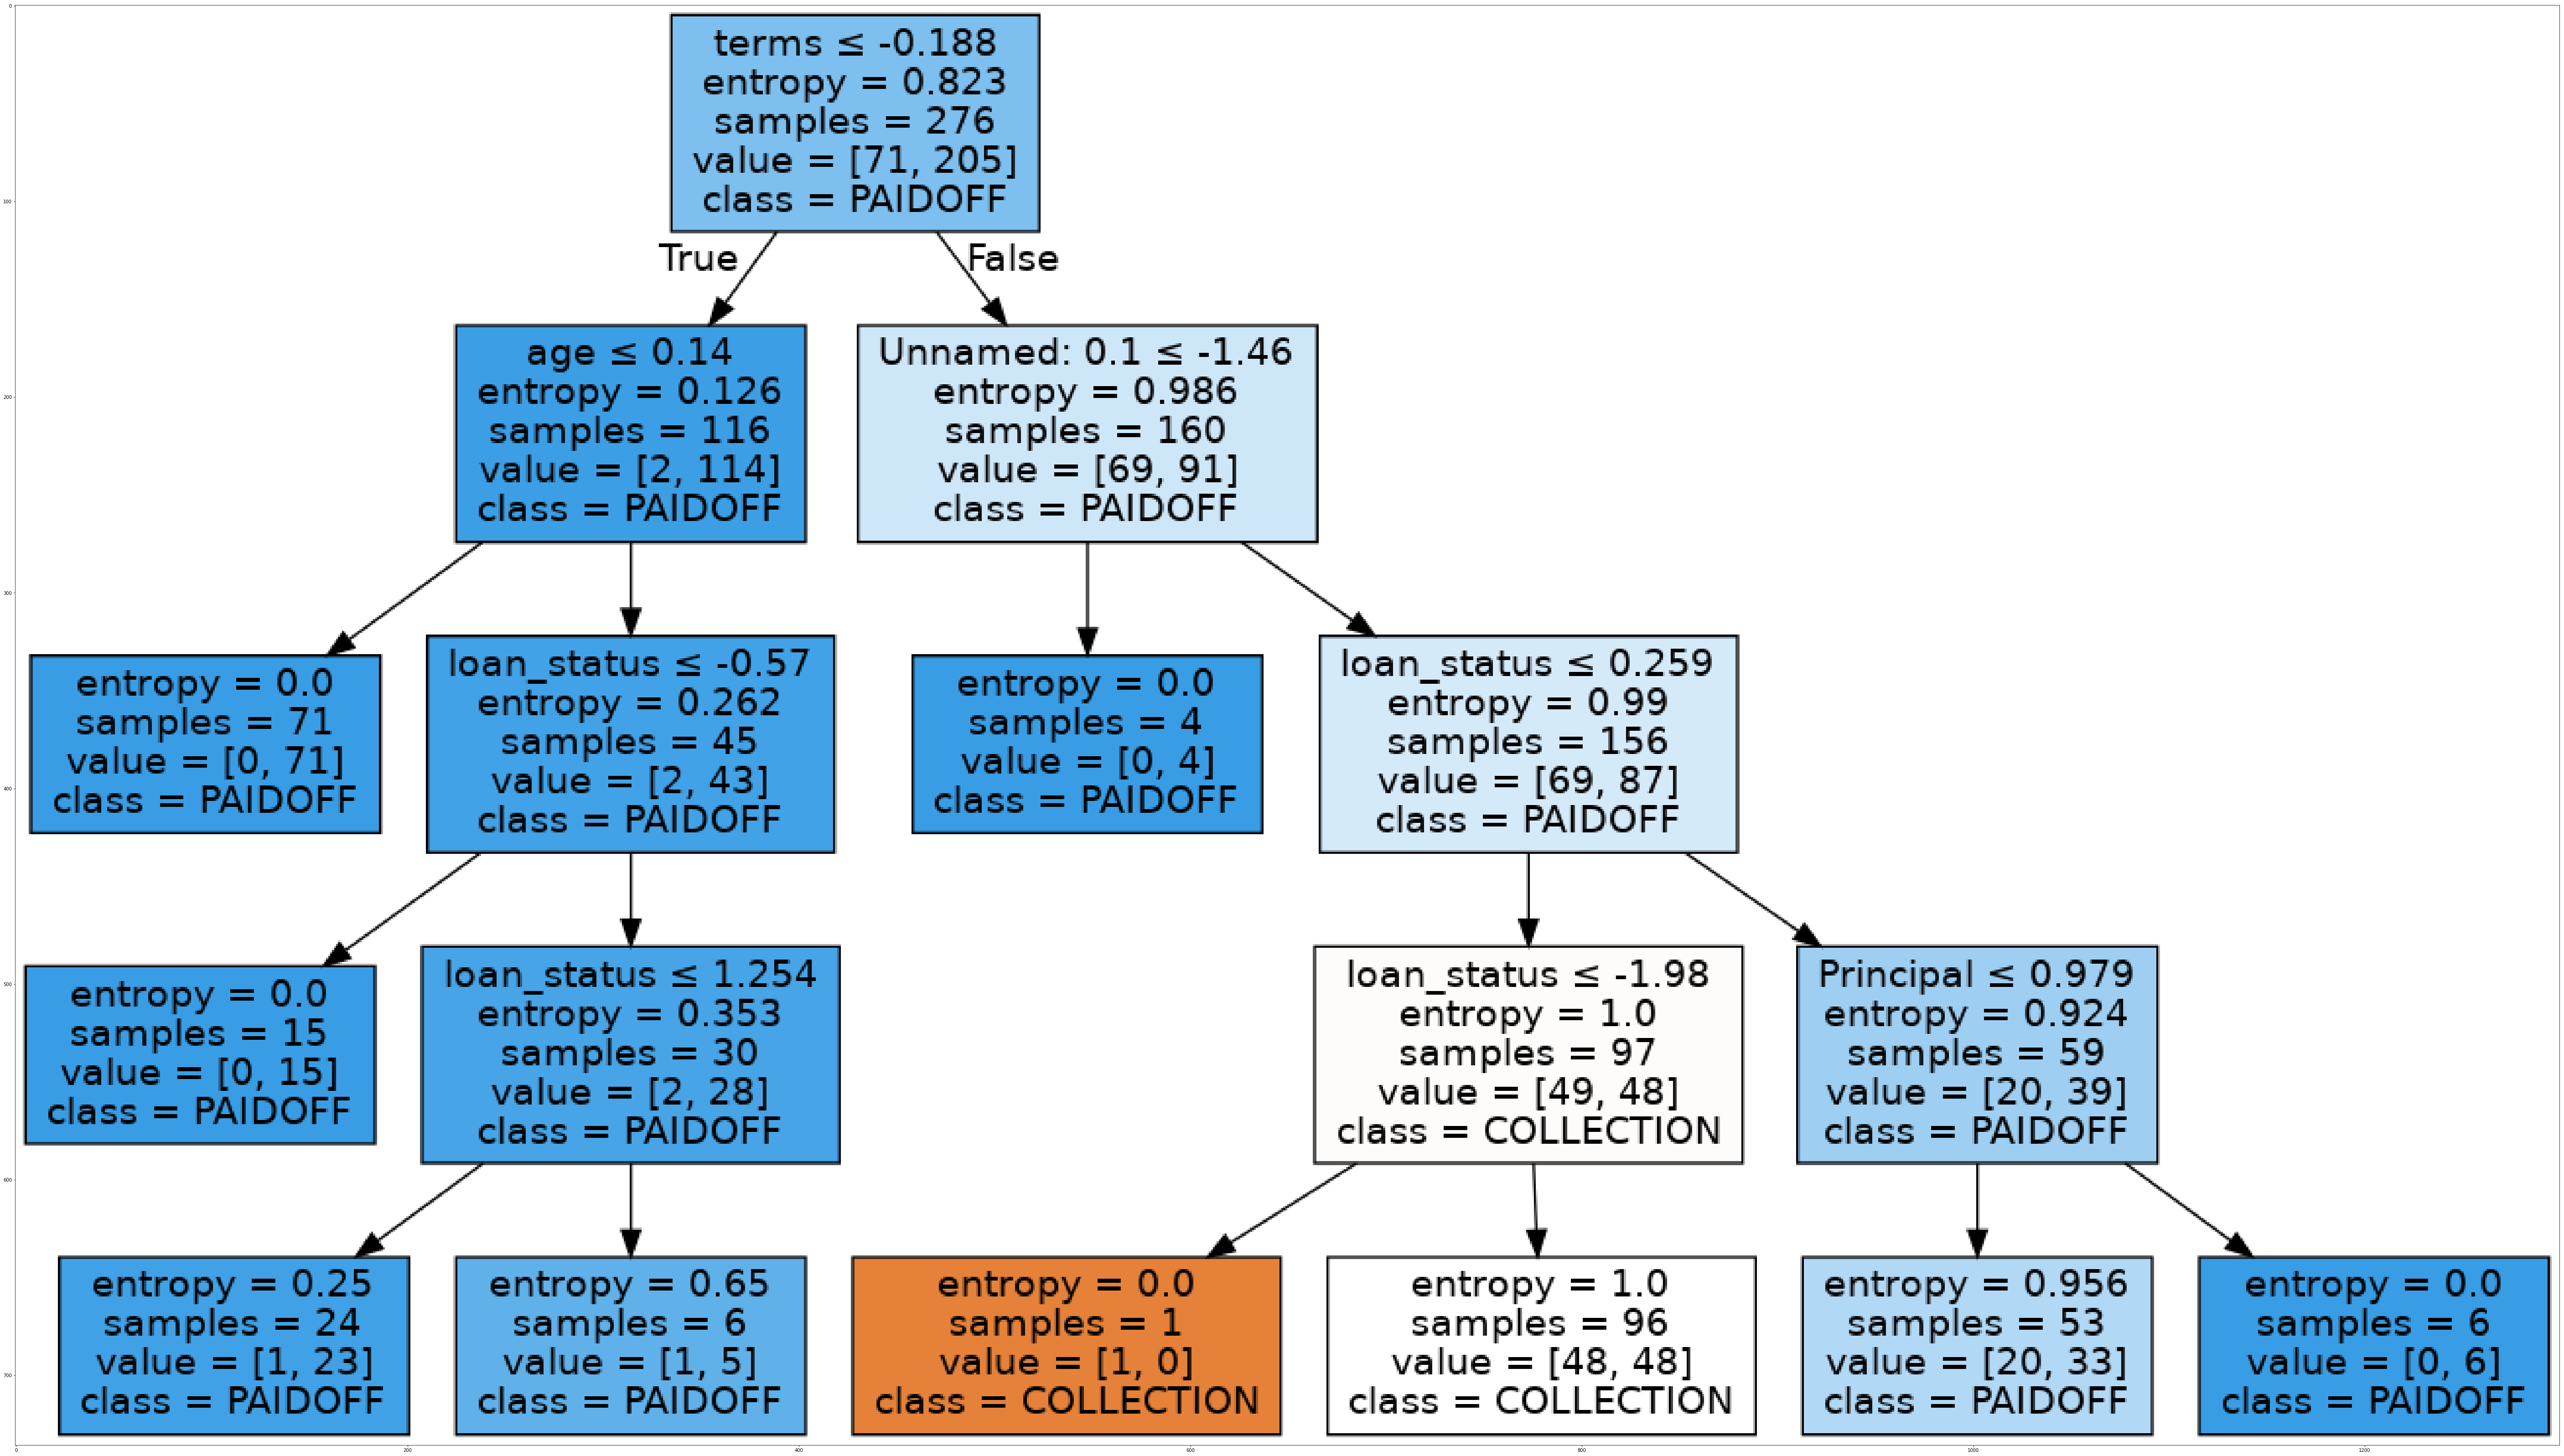

In [214]:
dot_data = StringIO()
filename = "Modeltree.png"
featureNames = df.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(ModelTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

### Let's start:

In [38]:
# importing aditional modules
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import jaccard_similarity_score

### I wonder about the sensibility of the SVM Model to distinct kernels. Let's try:

In [39]:
Kernels = ['rbf','linear','poly','sigmoid']
NK=len(Kernels)
mean_acc = np.zeros((NK))


for n in range(0,NK):
    
    #Train Model and Predict  
    DefSVM = svm.SVC(gamma='auto', kernel=Kernels[n])
    DefSVM.fit(X_train, y_train)
    ForeDefSVM = DefSVM.predict(X_test)
    mean_acc[n] = f1_score(y_test, ForeDefSVM, average='weighted')

    
    
mean_acc


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.7275882 , 0.69142857, 0.70647931, 0.68928571])

#### The above pink square is not an error, just a warning. It does not change the results!!!!

### The best f1 score is for a RBF model. So, let's use the RBF Kernel

In [40]:
DefSVM = svm.SVC(gamma='auto', kernel='rbf')
DefSVM.fit(X_train, y_train)
ForeDefSVM = DefSVM.predict(X_test)
print ("SVM Model F-score is:", f1_score(y_test, ForeDefSVM, average='weighted'))
ForeDefSVM

SVM Model F-score is: 0.7275882012724117


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [41]:
print( 'Jacard is: ', jaccard_similarity_score(y_test, ForeDefSVM))

Jacard is:  0.7428571428571429


### Let's check the Confusion Matrix:

In [52]:
#Defining the function...

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


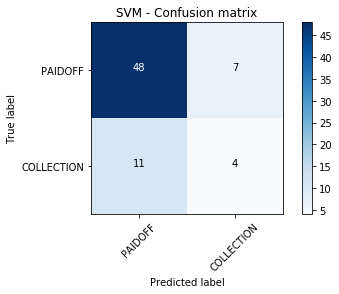

In [148]:
# Computing and ploting the confusion matrix ...
cnf_matrix = confusion_matrix(y_test, ForeDefSVM, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, ForeDefSVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='SVM - Confusion matrix')

# Logistic Regression

### Let's go straight to the point at this one...

In [47]:
# Importing Logistic Regression Model...
from sklearn.linear_model import LogisticRegression

In [48]:
# Fitting the model...
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
ForeLR = LR.predict(X_test)
ForeLR

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [50]:
ForeLR_prob = LR.predict_proba(X_test)
ForeLR_prob

array([[0.5034238 , 0.4965762 ],
       [0.45206111, 0.54793889],
       [0.30814132, 0.69185868],
       [0.34259428, 0.65740572],
       [0.32025894, 0.67974106],
       [0.31680537, 0.68319463],
       [0.48830185, 0.51169815],
       [0.47823073, 0.52176927],
       [0.34259428, 0.65740572],
       [0.4934056 , 0.5065944 ],
       [0.33806706, 0.66193294],
       [0.49662231, 0.50337769],
       [0.24891907, 0.75108093],
       [0.3419095 , 0.6580905 ],
       [0.43751789, 0.56248211],
       [0.25760497, 0.74239503],
       [0.52357188, 0.47642812],
       [0.30450278, 0.69549722],
       [0.50166363, 0.49833637],
       [0.3195971 , 0.6804029 ],
       [0.44276988, 0.55723012],
       [0.49410185, 0.50589815],
       [0.51350333, 0.48649667],
       [0.47203498, 0.52796502],
       [0.40944694, 0.59055306],
       [0.50846442, 0.49153558],
       [0.51098415, 0.48901585],
       [0.37457647, 0.62542353],
       [0.50418423, 0.49581577],
       [0.25299635, 0.74700365],
       [0.

Confusion matrix, without normalization
[[46  9]
 [13  2]]


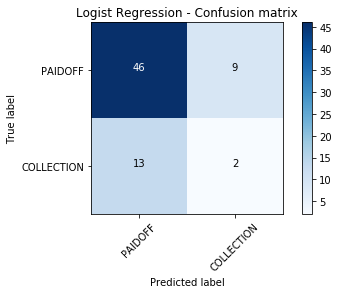

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, ForeLR, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Logist Regression - Confusion matrix')

In [54]:
print (classification_report(y_test, ForeLR))

              precision    recall  f1-score   support

  COLLECTION       0.18      0.13      0.15        15
     PAIDOFF       0.78      0.84      0.81        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [55]:
print('F1 score for the Logistic Regression is:', f1_score(y_test, ForeLR, average='weighted'))

F1 score for the Logistic Regression is: 0.6670522459996144


In [56]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, ForeLR)

0.6857142857142857

# Model Evaluation using Test set

In [30]:
from sklearn.metrics import jaccard_similarity_score
# from sklearn.metrics import f1_score, already imported
from sklearn.metrics import log_loss

First, download and load the test set:

In [153]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-29 02:52:52--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-03-29 02:52:52 (297 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [172]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Converting to date time object ....

In [173]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [ ]:
### Categorizing 'dayofweek' using feature binarization to set a threshold values less then day 4....

In [174]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [ ]:
### Replacing male/female by 0/1...

In [175]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


### One Hot Encoding ...

In [176]:
Feature_t = test_df[['Principal','terms','age','Gender','weekend']]
Feature_t = pd.concat([Feature_t,pd.get_dummies(test_df['education'])], axis=1)
Feature_t.drop(['Master or Above'], axis = 1,inplace=True)
Feature_t.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


### Attributing and normalizing ...

In [193]:
X_test_set=Feature_t
y_test_set=test_df['loan_status'].values
X_test_set= preprocessing.StandardScaler().fit(X_test_set).transform(X_test_set)
X_test_set

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86],
       [-1.24, -0.79,  0.2 , -0.51,  0.77, -0.42,  1.25, -0.86],
       [ 0.49, -0.79, -1.32, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [ 0.49,  0.93,  0.03, -0.51,  0.77,  2.4 , -0.8 , -0.86],
       [-0.67, -0.79, -0.81,  1.98,  0.77, -0.42, -0.8 ,  1.16],
       [ 0.49, -0.79,  0.87, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -1.32, -0.51,  0.77, -0.42,  1.25, -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [ 0.49,  0.93, -0.14, -0.51,  0.77,  2.4 , -0.8 , -0.86],
       [ 0.49,  0.93,  0.87,  1.98,  0.77, -0.42, -0.8 ,  1.16],
       [ 0.49,  0.93,  0.87,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93,  0.

#### The pink square above is not an error, just a warning! It does not change the results!!!

### Evaluating the KNN Algoritm using test set

In [215]:
#Predicting using X_test_set and Knn ...
yhat_t_knn=neigh.predict(X_test_set)


print('Jaccard for the KNN Algorithm is:', jaccard_similarity_score(y_test_set, yhat_t_knn))
print('F1 score for the KNN Algorithm is:', f1_score(y_test_set, yhat_t_knn, average='weighted'))

#Saving evaluation metrics into variables ...
jac_knn=round(jaccard_similarity_score(y_test_set, yhat_t_knn),2)
f1_knn=round(f1_score(y_test_set, yhat_t_knn, average='weighted'),2)

Jaccard for the KNN Algorithm is: 0.6666666666666666
F1 score for the KNN Algorithm is: 0.6328400281888654


### Evaluating the Decision tree using Test set

In [216]:
#Predicting using X_test_set and Decision Tree ....
yhat_t_tree = ModelTree.predict(X_test_set)


print('Jaccard for the Decision Tree Algorithm is:', jaccard_similarity_score(y_test_set, yhat_t_tree))
print('F1 score for the Decision Tree Algorithm is:', f1_score(y_test_set, yhat_t_tree, average='weighted'))

#Saving evaluation metrics into variables ...
jac_tree=round(jaccard_similarity_score(y_test_set, yhat_t_tree),2)
f1_tree=round(f1_score(y_test_set, yhat_t_tree, average='weighted'),2)


Jaccard for the Decision Tree Algorithm is: 0.7222222222222222
F1 score for the Decision Tree Algorithm is: 0.7366818873668188


### Evaluating the SVM using Test set

In [217]:
#Predicting using X_test_set and SVM ...
yhat_t_svm = DefSVM.predict(X_test_set)

print('Jaccard for the SVM Algorithm is:', jaccard_similarity_score(y_test_set, yhat_t_svm))
print('F1 score for the SVM Algorithm is:', f1_score(y_test_set, yhat_t_svm, average='weighted'))

#Saving evaluation metrics into variables ...
jac_svm=round(jaccard_similarity_score(y_test_set, yhat_t_svm),2)
f1_svm=round(f1_score(y_test_set, yhat_t_svm, average='weighted'),2)


Jaccard for the SVM Algorithm is: 0.7962962962962963
F1 score for the SVM Algorithm is: 0.7583503077293734


### Evaluating the Logistic Regression using Test set

In [218]:
#Importing LogLoss
from sklearn.metrics import log_loss

#Predicting using X_test_set and Logistic Regression
yhat_t_lr = LR.predict(X_test_set)

# Obtaining Predict_Proba using X_test_set...

yhat_prob_set = LR.predict_proba(X_test_set)

print('Jaccard for Logistic Regression is:', jaccard_similarity_score(y_test_set, yhat_t_lr))
print('F1 score for Logistic Regression is:', f1_score(y_test_set, yhat_t_lr, average='weighted'))
print('Log Loss Evaluation for Logistic Regression is:', log_loss(y_test_set, yhat_prob_set))

#Saving evaluation metrics into variables ...
jac_lr=round(jaccard_similarity_score(y_test_set, yhat_t_lr),2)
f1_lr=round(f1_score(y_test_set, yhat_t_lr, average='weighted'),2)
ll_lr=round(log_loss(y_test_set, yhat_prob_set),2)


Jaccard for Logistic Regression is: 0.7407407407407407
F1 score for Logistic Regression is: 0.6604267310789049
Log Loss Evaluation for Logistic Regression is: 0.5672153379912981


### Now, let's create a data frame to capture and display the final evaluation results!

In [219]:
data = {'Algorithm':  ['KNN', 'Decision Tree','SVM','LogisticRegression'],
        'Jaccard': [jac_knn, jac_tree, jac_svm, jac_lr],
        'F1-score': [f1_knn, f1_tree, f1_svm, f1_lr],
        'LogLoss': ['NA', 'NA', 'NA', ll_lr],
       }


df_eval_results = pd.DataFrame (data, columns = ['Algorithm','Jaccard', 'F1-score', 'LogLoss'])

df_eval_results

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.67,0.63,NA
1,Decision Tree,0.72,0.74,NA
2,SVM,0.80,0.76,NA
3,LogisticRegression,0.74,0.66,0.57


### The answer is above!  That's all folks !!!